-Each directory contains one CSV file with annotations ("GT-<ClassID>.csv") and the training images

-Each image is a traffic sign

-Image sizes varies 15x15 to 250x250

**Annotation Formation**

-Filename: Filename of corresponding image

-Width: Width of the image

-Height: Height of the image

-ROI.x1: X-coordinate of top-left corner of traffic sign bounding box

-ROI.y1: Y-coordinate of top-left corner of traffic sign bounding box

-ROI.x2: X-coordinate of bottom-right corner of traffic sign bounding box

-ROI.y2: Y-coordinate of bottom-right corner of traffic sign bounding box


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!pip install tensorflow_addons

In [3]:
import os
import pandas as pd
import random
import tensorflow as tf
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,Activation, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
import pathlib
import tensorflow_addons as tfa
import sys
from PIL import Image
vcpi = sys.modules[__name__] 



In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-05-31 15:56:34.743693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 15:56:34.762073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 15:56:34.762241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Default Values

In [5]:
N_classes = 43
data = []
directory_training = "./datasets/train"
directory_test = "./datasets/test"
model_directory = "./models/"
ensemble_directory = "./ensemble/"
BATCH_SIZE = 32
IMAGE_SIZE = 32
N_CHANNELS = 3 
KERNEL_SIZE = (5,5)
N_EPOCHS = 25
TRAIN_ONLINE = True

Filters
Ideas:
- Convert to RGB (grayscale I guess?)
- Translation
- Zooming
- Padding
- Change contrast 
- Use mean/median filters


In [6]:
N_FILTERS = 5
filters_name = ["rotate","brightness","shear","translate","saturation"]

In [7]:
def filter_rotate(image,label):
    #Rotate image 10 degrees
    image = tfa.image.rotate(image, 10)

    return image, label

In [8]:
def filter_brightness(image,label):
    # Increase brightness of image
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 1.0, 0.1, 3.0),0,1)

    return image, label

In [9]:
def filter_shear(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    sx = tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32)
    img = tfa.image.transform(img, [1, sx, -sx*32,   0,1,0,  0,0])
    return img, label

In [10]:
def filter_translate(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    tx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ty = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)  
    img = tfa.image.translate(img, [tx,ty])
    return img, label

In [11]:
def filter_saturation(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 3.0, 1.0, 1.0),0,1)
    return img, label

In [12]:
filters = []

for filtro in filters_name:
    func = getattr(vcpi, "filter_{}".format(filtro))
    filters.append(func)

Models

In [13]:
def model_1():
    model = Sequential()

    model.add(Conv2D(128, KERNEL_SIZE, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(196,KERNEL_SIZE))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(256,KERNEL_SIZE))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(LeakyReLU(alpha=0.00))
    model.add(Dense(384))
    model.add(LeakyReLU(alpha=0.00))
    model.add(Dropout(0.5))


    model.add(Dense(N_classes, activation='softmax'))

    apt = Adam(learning_rate=0.0001)
    model.compile(optimizer=apt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [14]:
def model_2():
    model = Sequential()

    model.add(Conv2D(64, KERNEL_SIZE, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(LeakyReLU(alpha=0.01))
        
    model.add(Conv2D(64,(5,5)))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(64,(5,5)))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())    
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Dense(N_classes, activation='softmax'))

    apt = Adam(learning_rate=0.0001)
    model.compile(optimizer=apt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
def model_3():
    model = Sequential()

    model.add(Conv2D(128, KERNEL_SIZE, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(196,KERNEL_SIZE))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(256,KERNEL_SIZE))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(512,KERNEL_SIZE))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(LeakyReLU(alpha=0.00))
    model.add(Dense(384))
    model.add(LeakyReLU(alpha=0.00))
    model.add(Dropout(0.5))


    model.add(Dense(N_classes, activation='softmax'))

    apt = Adam(learning_rate=0.0001)
    model.compile(optimizer=apt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [16]:
def model_4():
    model = Sequential()

    model.add(Conv2D(128, KERNEL_SIZE, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(196,KERNEL_SIZE))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(1,1),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(256,KERNEL_SIZE))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(512,KERNEL_SIZE))
    model.add(Conv2D(512,KERNEL_SIZE))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(LeakyReLU(alpha=0.00))
    model.add(Dense(384))
    model.add(LeakyReLU(alpha=0.00))
    model.add(Dropout(0.5))


    model.add(Dense(N_classes, activation='softmax'))

    apt = Adam(learning_rate=0.0001)
    model.compile(optimizer=apt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
# Adding to models
models = []
models_augmentation = []

N_MODELS = 4

for i in range(N_MODELS):
    func = getattr(vcpi, "model_{}".format(i + 1))
    models.append(func())
    models_augmentation.append(func())

2022-05-31 15:56:35.049644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-31 15:56:35.050680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 15:56:35.050901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 15:56:35.051047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [18]:
classNames = np.array(os.listdir(directory_training))
classNames

array(['00001', '00023', '00032', '00033', '00004', '00013', '00002',
       '00015', '00021', '00011', '00022', '00028', '00037', '00026',
       '00020', '00000', '00008', '00029', '00019', '00003', '00006',
       '00031', '00025', '00018', '00024', '00010', '00007', '00030',
       '00039', '00014', '00005', '00009', '00016', '00035', '00042',
       '00038', '00036', '00040', '00012', '00041', '00017', '00027',
       '00034'], dtype='<U5')

Converting Images to .png [data training]

In [19]:
#for i in range (N_classes):
#    
#    path = os.path.join(directory_training, format(i, '05d'))
#    files = os.listdir(path)
#    csv = ""
#    
#    for file in files:
#        try:
#            image = Image.open(os.path.join(path,file))
#            image.save(f"{path}/{file.split('.')[0]}.png")
#        except:
#            pass    
# 

Converting Images to .png [data test]

In [20]:
#for i in range (N_classes):
#    
#    path = os.path.join(directory_test, format(i, '05d'))
#    files = os.listdir(path)
#    
#    for file in files:
#        try:
#            image = Image.open(os.path.join(path,file))
#            image.save(f"{path}/{file.split('.')[0]}.png")
#        except:
#            pass    
#

Saving images


In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data = tf.data.Dataset.list_files(f"{directory_training}/*/*.png", shuffle=False)
image_count = len(data)
 

# Preparing datasets

## Aux functions

In [22]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == classNames

In [23]:
def get_img_label(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    return img,label

In [24]:
dataset = data.map(get_img_label, num_parallel_calls=AUTOTUNE)
dataset_length = len(dataset)
print(dataset_length)

39209


Spliting dataset into training and validation sets, we using 80% and 20%.

In [25]:
val_size = int(image_count * 0.2)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

In [26]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
val_ds_size = tf.data.experimental.cardinality(val_ds).numpy()

print(train_ds_size)
print(val_ds_size)

31368
7841


Configuring dataset, to train a model it's important to have data to be well shuffled and to be batched

In [27]:
def configure_datasets(dataset, cond): 
    dataSolo = dataset.cache()
    # note: works the best if buffer size >= the full of size of the dataset
    dataSolo = dataSolo.shuffle(buffer_size = len(dataSolo))

    # note2: we might need to tune or we just use autotune 
    dataSolo = dataSolo.prefetch(buffer_size = len(dataSolo))

    dataSolo = dataSolo.batch(batch_size=BATCH_SIZE)
    
    # note3: this allows later elements to be prepared while current element is being processed
    # note4: it should end with a call to prefetch
    
    if cond == 1 : 
        dataSolo = dataSolo.repeat()

    return dataSolo

In [28]:
train_ds = configure_datasets(train_ds,0)
val_ds = configure_datasets(val_ds,0)

In [29]:
test_set = tf.data.Dataset.list_files(f"{directory_test}/*/*.png")
test_set = test_set.map(get_img_label, num_parallel_calls=AUTOTUNE)
data_test_set = test_set.batch(batch_size=BATCH_SIZE)

In [30]:
i = 0
image_batch, label_batch = next(iter(train_ds))  

# TODO: FIX THIS IMAGES
# plt.figure(figsize=(10, 10))
# for i in range(25):
#   ax = plt.subplot(5, 5, i + 1)
#   plt.imshow(image_batch[i])
#   plt.axis("off")


Training Model

In [31]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, monitor = 'val_accuracy', verbose=1, save_weights_only=True, save_best_only=True)
    earlyStopper = EarlyStopping(monitor='val_accuracy', min_delta = 0.00001, patience = 15, verbose = 1)
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

In [32]:
histories = []
i = 0

for model in models:
    file_path = f"{model_directory}/model{i}/cp.ckpt"
    callbacks = prepare_callbacks(file_path)

    history = model.fit(
        train_ds, 
        epochs = N_EPOCHS,
        validation_data=val_ds,
        callbacks=callbacks
    )
    
    histories.append(history)
    i += 1  

Epoch 1/25


2022-05-31 15:56:39.692928: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


  1/981 [..............................] - ETA: 32:04 - loss: 5.7484 - accuracy: 0.0000e+00

2022-05-31 15:56:40.516433: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


981/981 [==============================] - ETA: 0s - loss: 1.7794 - accuracy: 0.5298
Epoch 1: val_accuracy improved from -inf to 0.01530, saving model to ./models//model0/cp.ckpt
981/981 [==============================] - 10s 8ms/step - loss: 1.7794 - accuracy: 0.5298 - val_loss: 9.7407 - val_accuracy: 0.0153 - lr: 1.0000e-04
Epoch 2/25
978/981 [============================>.] - ETA: 0s - loss: 0.3924 - accuracy: 0.8812
Epoch 2: val_accuracy improved from 0.01530 to 0.16911, saving model to ./models//model0/cp.ckpt
981/981 [==============================] - 7s 7ms/step - loss: 0.3921 - accuracy: 0.8813 - val_loss: 12.2331 - val_accuracy: 0.1691 - lr: 1.0000e-04
Epoch 3/25
978/981 [============================>.] - ETA: 0s - loss: 0.1723 - accuracy: 0.9465
Epoch 3: val_accuracy did not improve from 0.16911
981/981 [==============================] - 7s 7ms/step - loss: 0.1721 - accuracy: 0.9466 - val_loss: 14.6217 - val_accuracy: 0.1650 - lr: 1.0000e-04
Epoch 4/25
978/981 [==============

In [33]:
def show_history(history):

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()   

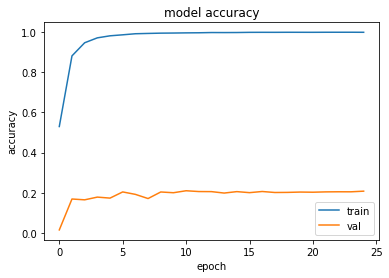

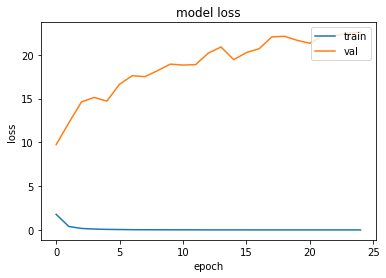

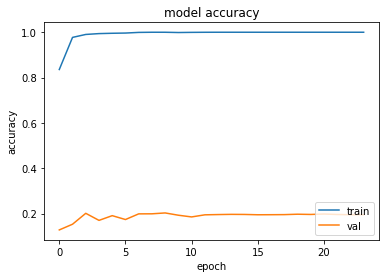

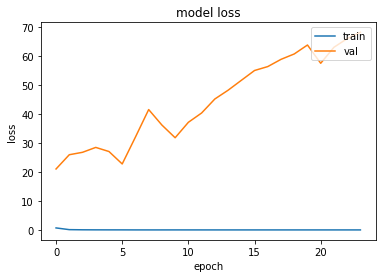

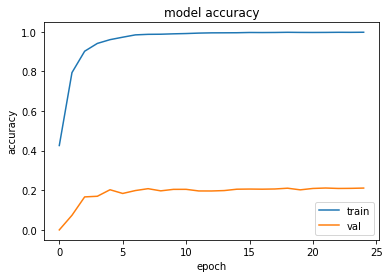

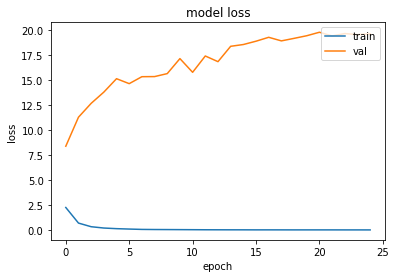

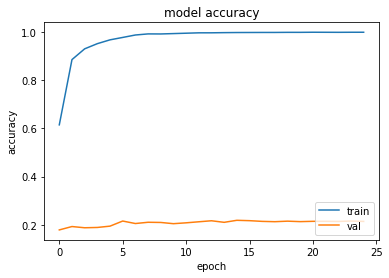

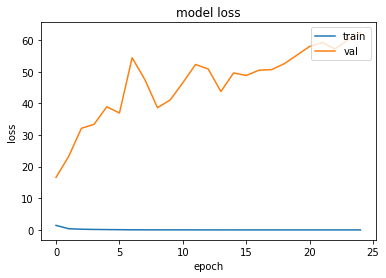

In [34]:
for i in range (N_MODELS):
    show_history(histories[i])

In [35]:
evaluate_testset = []

Evaluating all models

In [36]:
i = 0

for i in range(N_MODELS) :
    models[i].load_weights(f"{model_directory}/model{i}/cp.ckpt")
    evaluate_testset.append(models[i].evaluate(data_test_set))

395/395 [==============================] - 3s 8ms/step - loss: 10.5938 - accuracy: 0.8254


# Version with data augmentation

Data augmentation is the process of modifying/augmenting a dataset with additional data and it's used in machine learning to help improve their performance. Even a basic data augmentation can improve accuracy.

Ideas:
- Remove noise using mean/median for every image, some of them have some noise and blur
- Rotation
- Increase brigthness
- Flip
- Translation
- Crop 
- Saturation
- Change RGB


Some interesting links:
- https://www.tensorflow.org/tutorials/images/data_augmentation
- https://www.tensorflow.org/tutorials/images/segmentation
- https://www.tensorflow.org/addons/tutorials/image_ops



In [37]:
data_augmentation = data 
data_augmentation = data_augmentation.map(get_img_label, num_parallel_calls=AUTOTUNE)

train_ds_v2 = data_augmentation

for filtro in filters:
    train_ds_v2 = train_ds_v2.concatenate(data_augmentation.map(filtro))

train_ds_v2 = configure_datasets(train_ds_v2,0)

image_count = len(train_ds_v2)


In [38]:
# val_size = int(image_count * 0.2)
# train_ds_augmentation = train_ds_v2.skip(val_size)
# val_ds_augmentation = train_ds_v2.take(val_size)

In [39]:
# train_ds_augmentation_size = tf.data.experimental.cardinality(train_ds_augmentation).numpy()
# val_ds_augmentation_size = tf.data.experimental.cardinality(val_ds_augmentation).numpy()
# 
# print(train_ds_augmentation_size)
# print(val_ds_augmentation_size)

In [40]:
# train_ds_augmentation = configure_datasets(train_ds_augmentation,1)
# val_ds_augmentation = configure_datasets(val_ds_augmentation,1)

In [41]:
historiesV2 = []
i = N_MODELS 

for model in models_augmentation:
    file_path = f"{model_directory}/model{i}/cp.ckpt"
    callbacks = prepare_callbacks(file_path)



    history = model.fit(
        train_ds_v2, 
        epochs = N_EPOCHS,
        validation_data=val_ds,
        callbacks=callbacks
    )
    
    historiesV2.append(history)
    i += 1  

Epoch 1/25


2022-05-31 16:17:44.676060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 192730 of 235254


  25/7352 [..............................] - ETA: 48s - loss: 4.6323 - accuracy: 0.0487       

2022-05-31 16:17:46.164046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


7352/7352 [==============================] - ETA: 0s - loss: 0.9268 - accuracy: 0.7299
Epoch 1: val_accuracy improved from -inf to 0.99605, saving model to ./models//model4/cp.ckpt
7352/7352 [==============================] - 64s 7ms/step - loss: 0.9268 - accuracy: 0.7299 - val_loss: 0.0237 - val_accuracy: 0.9960 - lr: 1.0000e-04
Epoch 2/25
7349/7352 [============================>.] - ETA: 0s - loss: 0.1705 - accuracy: 0.9466
Epoch 2: val_accuracy improved from 0.99605 to 0.99885, saving model to ./models//model4/cp.ckpt
7352/7352 [==============================] - 53s 7ms/step - loss: 0.1705 - accuracy: 0.9466 - val_loss: 0.0077 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 3/25
7352/7352 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.9704
Epoch 3: val_accuracy improved from 0.99885 to 0.99962, saving model to ./models//model4/cp.ckpt
7352/7352 [==============================] - 53s 7ms/step - loss: 0.0953 - accuracy: 0.9704 - val_loss: 0.0033 - val_accuracy: 

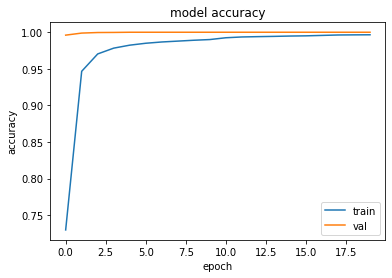

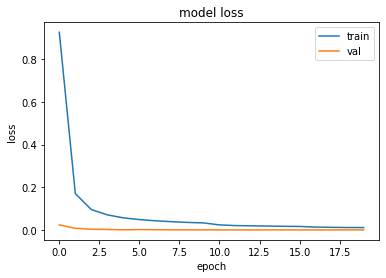

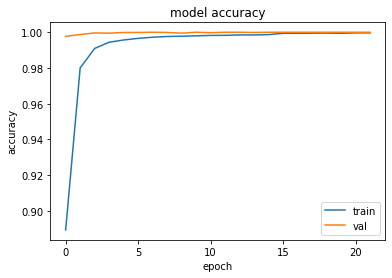

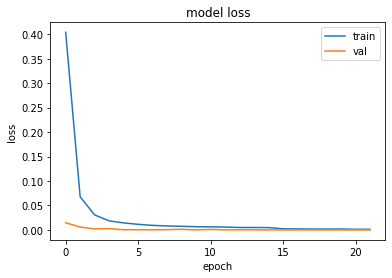

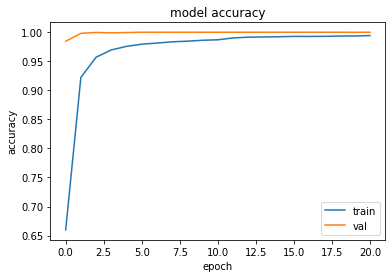

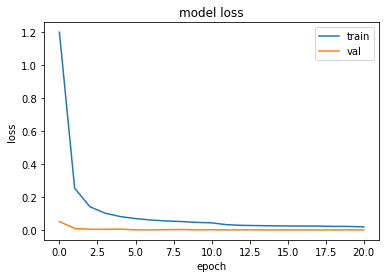

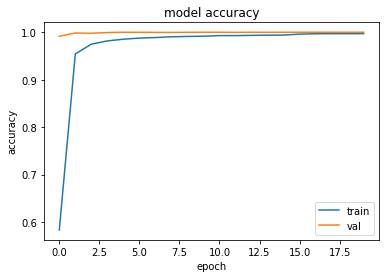

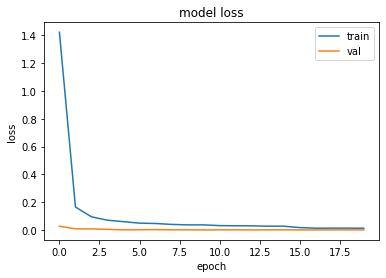

In [42]:
for i in range (N_MODELS):
    show_history(historiesV2[i])

In [43]:
evaluate_testset_aug = []

In [44]:
for i in range(N_MODELS) :
    models_augmentation[i].load_weights(f"{model_directory}/model{i + N_MODELS}/cp.ckpt")
    evaluate_testset_aug.append(models_augmentation[i].evaluate(data_test_set))

395/395 [==============================] - 3s 7ms/step - loss: 0.0290 - accuracy: 0.9926


In [47]:
def show_wrong_predictions(models_to_show):
    for i in range (N_MODELS):
        numpy_labels = []
        numpy_images = []
        pred = []

        for images, labels in data_test_set.take(-1): 
            numpy_images.extend(images.numpy())
            numpy_labels.extend(labels.numpy())
            pred.extend(models_to_show[i].predict(images.numpy()))

        count = 0
        i = 0
        wrong_predict = [] 

        while count < 10: 
            gt = np.where(numpy_labels[i])[0][0]
            if gt != np.argmax(pred[i]):
                # add to wrong_predict
                wrong_predict.append(i)
                count += 1
                i += 1
            else:
                i += 1

        f, axes = plt.subplots(5,5,figsize=(12,12))
        fig = plt.figure()
        for i in range(10):
            #subplot_title=("class " + label_batch.numpy())
            #axes.ravel()[i].set_title(subplot_title)
            axes.ravel()[i].imshow(numpy_images[wrong_predict[i]])
            axes.ravel()[i].axis('off')

    plt.show()

1/1 [==============================] - 0s 62ms/step


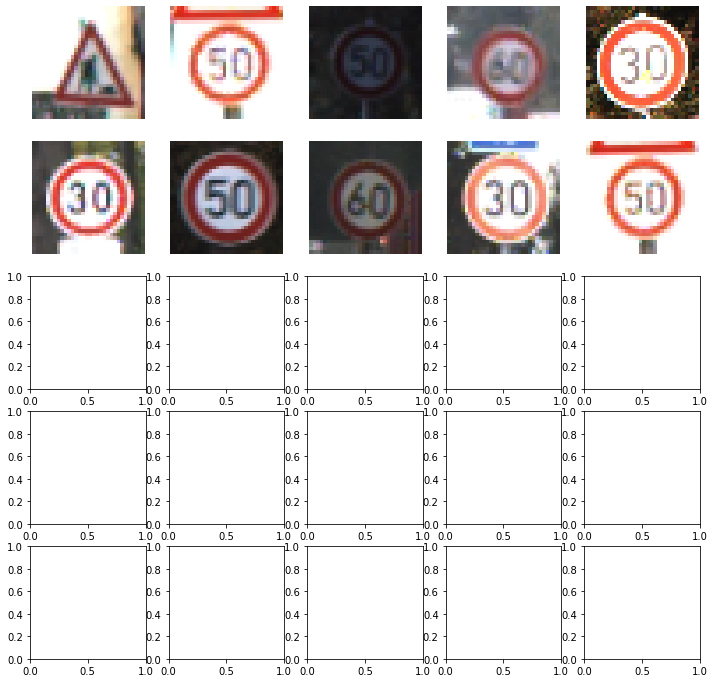

<Figure size 432x288 with 0 Axes>

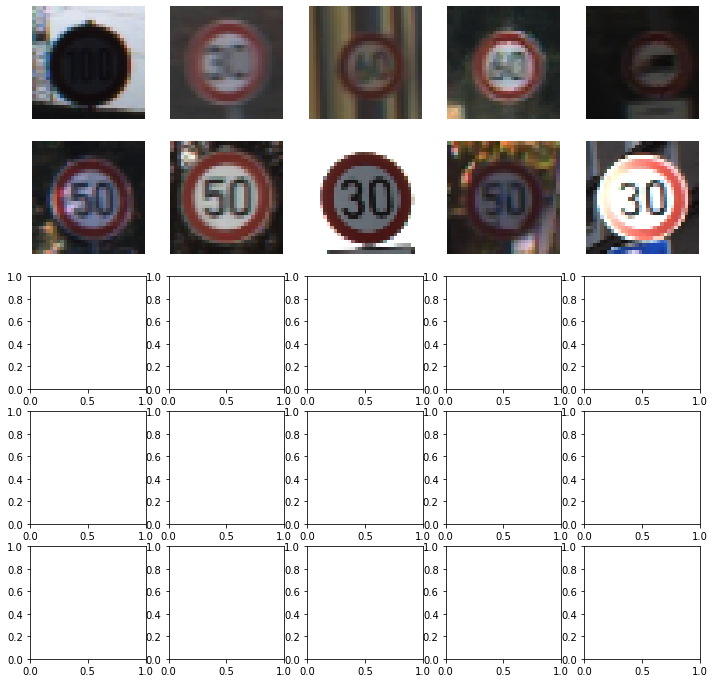

<Figure size 432x288 with 0 Axes>

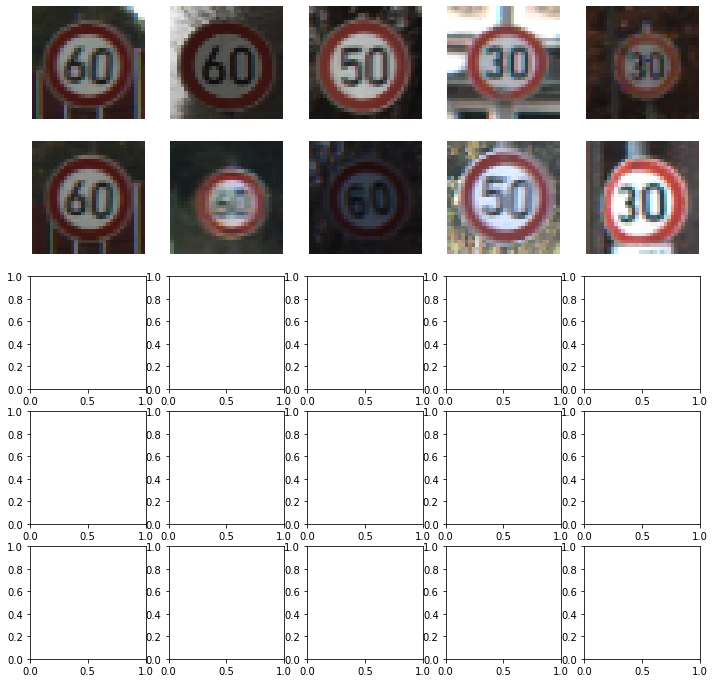

<Figure size 432x288 with 0 Axes>

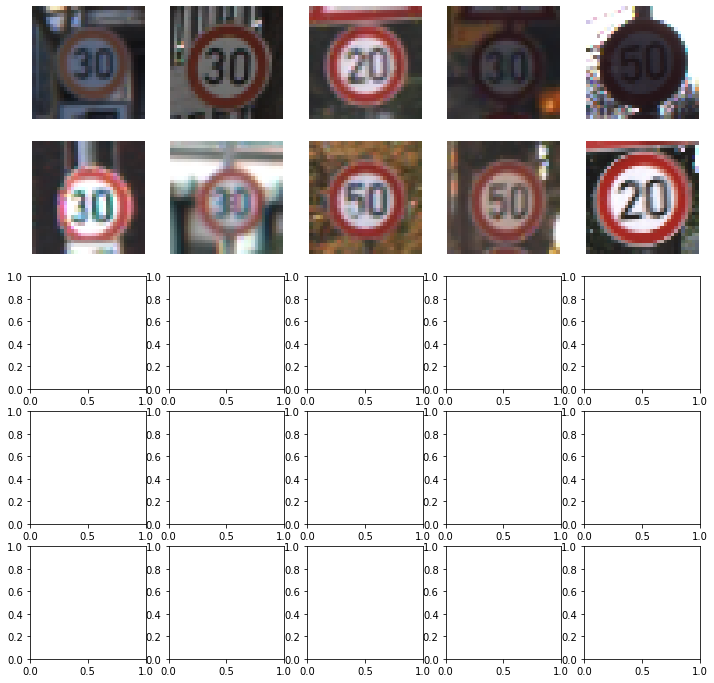

<Figure size 432x288 with 0 Axes>

In [48]:
show_wrong_predictions(models)

1/1 [==============================] - 0s 67ms/step


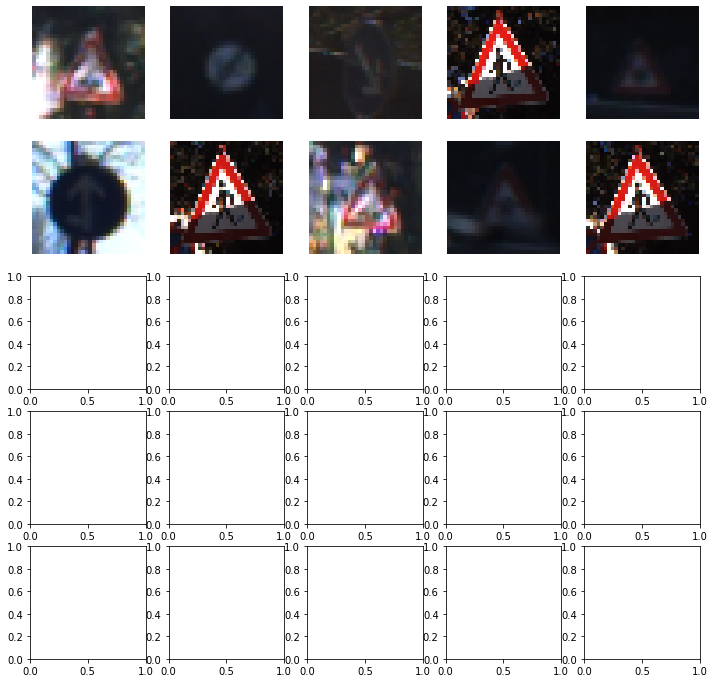

<Figure size 432x288 with 0 Axes>

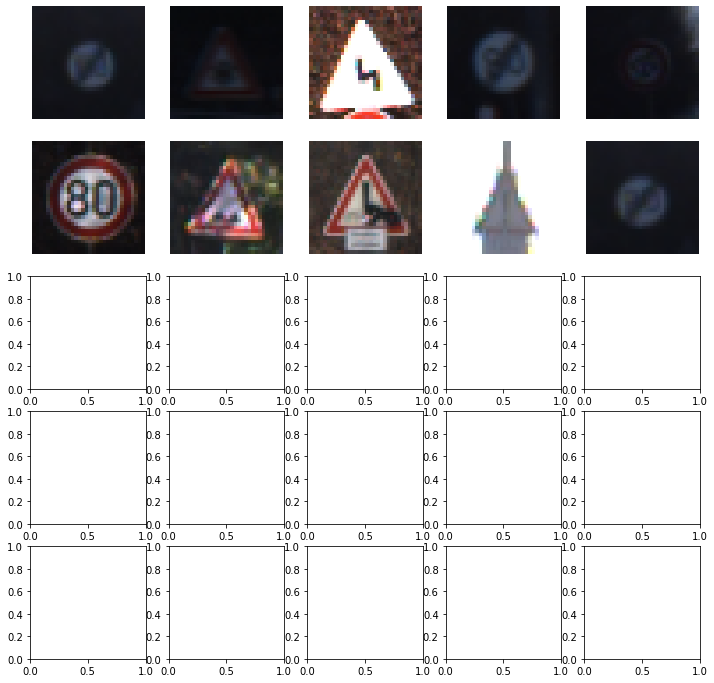

<Figure size 432x288 with 0 Axes>

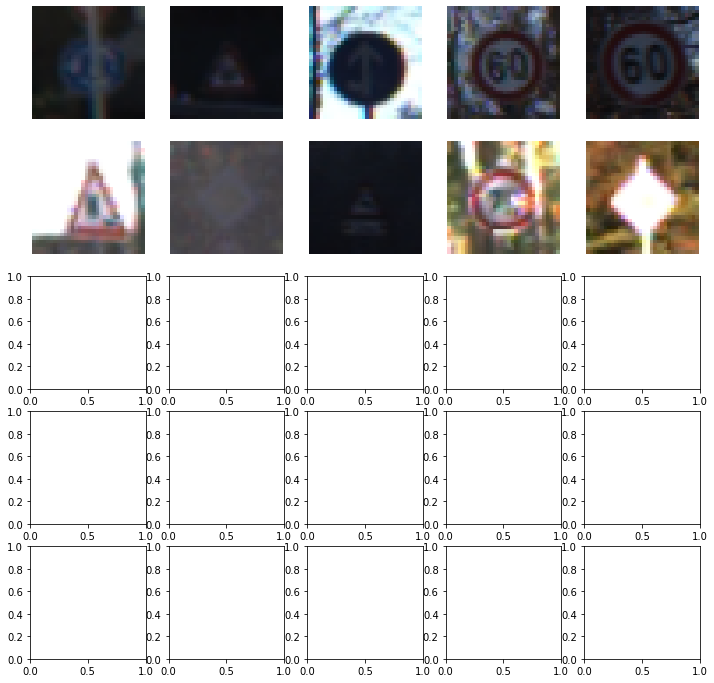

<Figure size 432x288 with 0 Axes>

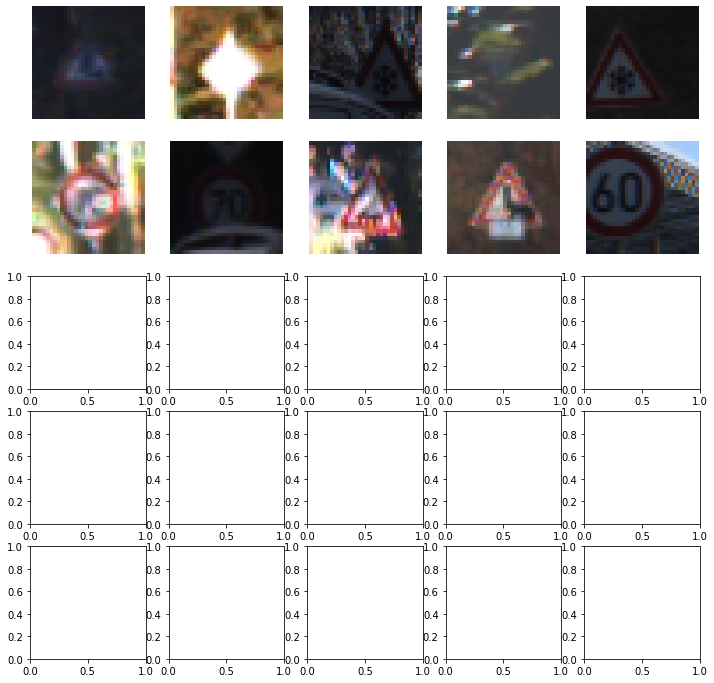

<Figure size 432x288 with 0 Axes>

In [49]:
show_wrong_predictions(models_augmentation)